# Introduction

In a prior notebook, documents were partitioned by assigning them to the domain with the highest Dice similarity of their term and structure occurrences. Here, we'll assess whether the observed modularity of the partitions is greater than expected by chance. Modularity will be measured by the ratio of dispersion between partitions to dispersion within partitions.

# Load the data

In [1]:
import pandas as pd
import numpy as np
from modularity import *

In [2]:
framework = "data-driven" 
version = 190325 # Document-term matrix version
suffix = "" # Suffix for term lists
n_iter = 10000 # Iterations for null distribution
dx = [0.36, 0.37, 0.37, 0.38, 0.37, 0.375, 0.37] # Nudges for plotted means
ds = 0.1 # Nudges for plotted stars

## Brain activation coordinates

In [3]:
act_bin = load_coordinates()
print("Document N={}, Structure N={}".format(
      act_bin.shape[0], act_bin.shape[1]))

Document N=18155, Structure N=114


## Document-term matrix

In [4]:
dtm_bin = load_doc_term_matrix(version=version, binarize=True)
print("Document N={}, Term N={}".format(
      dtm_bin.shape[0], dtm_bin.shape[1]))

Document N=18155, Term N=4107


## Domain archetypes

In [5]:
from collections import OrderedDict

In [6]:
lists, circuits = load_framework(framework, suffix=suffix)

In [7]:
words = sorted(list(set(lists["TOKEN"])))
structures = sorted(list(set(act_bin.columns)))
domains = list(OrderedDict.fromkeys(lists["DOMAIN"]))

In [8]:
archetypes = pd.DataFrame(0.0, index=words+structures, columns=domains)
for dom in domains:
    for word in lists.loc[lists["DOMAIN"] == dom, "TOKEN"]:
        archetypes.loc[word, dom] = 1.0
    for struct in structures:
        archetypes.loc[struct, dom] = circuits.loc[struct, dom]
archetypes[archetypes > 0.0] = 1.0
print("Term & Structure N={}, Domain N={}".format(
      archetypes.shape[0], archetypes.shape[1]))

Term & Structure N=228, Domain N=7


## Document structure-term vectors

In [9]:
pmids = dtm_bin.index.intersection(act_bin.index)
len(pmids)

18155

In [10]:
dtm_words = dtm_bin.loc[pmids, words]
act_structs = act_bin.loc[pmids, structures]

In [11]:
docs = dtm_words.copy()
docs[structures] = act_structs.copy()
docs.head()

,action,addiction,anticipation,arousal,articulation,attention,audition,auditory_feedback,auditory_perception,autobiographical_memory,...,right_superior_temporal_gyrus_posterior_division,right_supplementary_motor_cortex,right_supracalcarine_cortex,right_supramarginal_gyrus_anterior_division,right_supramarginal_gyrus_posterior_division,right_temporal_fusiform_cortex_anterior_division,right_temporal_fusiform_cortex_posterior_division,right_temporal_occipital_fusiform_cortex,right_temporal_pole,right_thalamus
10022492,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,0,0,0,1
10022494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,0,0,0,1,0,0
10022496,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,0
10027301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
10051677,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,0,1,1


## Document assignments

In [12]:
doc2dom_df = pd.read_csv("../partition/data/doc2dom_{}.csv".format(framework), 
                         header=None, index_col=0)
doc2dom = {int(pmid): int(dom) for pmid, dom in doc2dom_df.iterrows()}

In [13]:
dom2docs = {dom: [] for dom in domains}
for doc, dom in doc2dom.items():
    dom2docs[domains[dom-1]].append(doc)

# Compute domain modularity

In [14]:
from scipy.spatial.distance import cdist

## Observed values

In [15]:
centroid = np.mean(docs).values
df_obs = pd.DataFrame(index=domains, columns=pmids)
df = pd.DataFrame(index=domains, columns=["OBSERVED"])
for dom in domains:
    dom_pmids = dom2docs[dom]
    dom_vecs = docs.loc[dom_pmids].values
    dom_centroid = np.mean(dom_vecs, axis=0)
    dist_ext = (dom_vecs - centroid) ** 2
    dist_int = (dom_vecs - dom_centroid) ** 2
    df_obs.loc[dom, dom_pmids] = np.sum(dist_ext, axis=1) / np.sum(dist_int, axis=1)
    df.loc[dom, "OBSERVED"] = np.mean(np.sum(dist_ext) / np.sum(dist_int))
df.head(8)

,OBSERVED
MEMORY,1.30749
REWARD,1.41526
COGNITION,1.0469
VISION,1.06692
MANIPULATION,1.03253
MEANING,1.21427
LANGUAGE,1.1879


## Null distributions

In [16]:
import os

In [17]:
file_null = "data/mod_null_{}_{}iter.csv".format(framework, n_iter)
if not os.path.isfile(file_null):
    df_null = np.empty((len(domains), n_iter))
    for n in range(n_iter):
        null = np.random.choice(range(docs.shape[1]), size=docs.shape[1], replace=False)
        centroid = np.mean(docs)[null].values
        for i, dom in enumerate(domains):
            dom_pmids = dom2docs[dom]
            dom_vecs = docs.loc[dom_pmids].values
            dom_centroid = np.mean(dom_vecs, axis=0)[null]
            n_docs = dom_vecs.shape[0]
            dist_ext = (dom_vecs - centroid) ** 2
            dist_int = (dom_vecs - dom_centroid) ** 2
            df_null[i,n] = np.sum(dist_ext) / np.sum(dist_int)
        if n % int(n_iter / 10.0) == 0:
            print("Processed {} iterations".format(n))
    df_null = pd.DataFrame(df_null, index=domains, columns=range(n_iter))
    df_null.to_csv(file_null)
else:
    df_null = pd.read_csv(file_null, index_col=0, header=0)

Processed 0 iterations
Processed 1000 iterations
Processed 2000 iterations
Processed 3000 iterations
Processed 4000 iterations
Processed 5000 iterations
Processed 6000 iterations
Processed 7000 iterations
Processed 8000 iterations
Processed 9000 iterations


# Perform significance testing

In [18]:
from statsmodels.stats import multitest

In [19]:
alphas = [0.0001, 0.00001, 0.000001]
stars = ["*", "**", "***"]

In [20]:
pval = []
for dom in domains:   
    dom_null = df_null.loc[dom].values
    dom_obs = float(df.loc[dom, "OBSERVED"])
    p = np.sum(dom_null >= dom_obs) / float(n_iter)
    pval.append(p)
    df.loc[dom, "P"] = p
df["FDR"] = multitest.multipletests(pval, method="fdr_bh")[1]
for dom in domains:
    for star, alpha in zip(stars, alphas):
        if df.loc[dom, "FDR"] < alpha:
            df.loc[dom, "STARS"] = star
        else:
            df.loc[dom, "STARS"] = ""
df = df.loc[domains, ["OBSERVED", "P", "FDR", "STARS"]]
df

,OBSERVED,P,FDR,STARS
MEMORY,1.30749,0.0,0.0,***
REWARD,1.41526,0.0,0.0,***
COGNITION,1.0469,0.0,0.0,***
VISION,1.06692,0.0,0.0,***
MANIPULATION,1.03253,0.0,0.0,***
MEANING,1.21427,0.0,0.0,***
LANGUAGE,1.1879,0.0,0.0,***


# Plot results

In [21]:
%matplotlib inline

In [22]:
palette = palettes[framework]

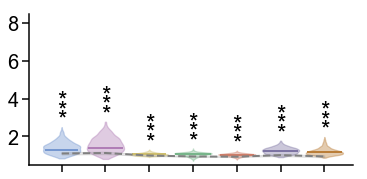

In [23]:
plot_violins(framework, domains, df, df_null, df_obs, palette, 
             dx=dx, ds=ds, alphas=alphas, interval=0.999)